In [1]:
from PIL import Image
import os
import cv2
import random
import math
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
base_path = "./datasets/seg-14/train"
destination = "./datasets/bb-14-aug"
crop_size = 224

In [4]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1),
        A.ToGray(p=0.15)  # Grayscale with max alpha 0.15
    ], p=1),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0, 1), p=1),
        A.Blur(blur_limit=(3, 3), p=1),  # AverageBlur with kernel size 2-3
        A.MedianBlur(blur_limit=3, p=1),
        A.GaussNoise(var_limit=(0.0, 0.01 * 255), p=1),
        A.ElasticTransform(alpha=2, sigma=1, p=1)
    ], p=1),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

rotate = A.Compose([
    A.Rotate(limit=90, p=1),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [5]:
mask_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".txt"):
            mask_paths.append(os.path.join(root, file))

In [6]:
!ls datasets/seg-14

data.yaml  README.dataset.txt  README.roboflow.txt  train


In [7]:
count = 0
image_and_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # mask_path = os.path.join(base_path, image_path.split("/")[2], "labels", os.path.basename(image_path).replace(".jpg", ".txt"))
            mask_path = os.path.join(base_path, "labels", os.path.basename(image_path).replace(".jpg", ".txt"))
            try:
                with open(mask_path, "r") as mask_file:
                    lines = mask_file.readlines()
                    empty = len(lines) == 0
                    image_and_paths.append((image, lines, file, empty))
            except FileNotFoundError:
                print(f"File not found: {mask_path}")
                lines = []
                empty = True
                image_and_paths.append((image, lines, file, empty))
                count += 1
print(f"Files not found: {count}")

Files not found: 0


In [8]:
count_dict = {}

for image_and_path in image_and_paths:
    _, _, s, _ = image_and_path
    number = s.split('_')[0]
    try:
        number = int(number)
    except:
        print(number)
        if -1 in count_dict:
            count_dict[-1] += 1
        else:
            count_dict[-1] = 1
        continue

    if number in count_dict:
        count_dict[number] += 1
    else:
        count_dict[number] = 1

sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)

# total = 0
# for number, count in sorted_counts:
#     print(f"Number {number}: {count} instance(s)")

2021-09-01
2021-11-19
2019-09-01
2022-02-07
2019-12-29
2021-10-10
2021-12-29
2019-10-10
2022-09-01
2021-03-19


In [9]:
test_numbers = []
total = 0
for number, count in sorted_counts:
    if (count > 1 and count < 6) and number not in test_numbers:
        test_numbers.append(number)
        total += count
print(f"Total: {total}")

Total: 163


In [10]:
import copy
val_numbers = copy.deepcopy(test_numbers)

In [11]:
# val_numbers = []
# total = 0
# for number, count in sorted_counts:
#     if (count > 2 and count < 6) and number not in val_numbers:
#         val_numbers.append(number)
#         total += count
# print(f"Total: {total}")

In [12]:
test_image_and_paths = []
for image_and_path in image_and_paths:
    image, lines, file, empty = image_and_path
    try:
        number = int(file.split('_')[0])
    except:
        number = -1
    if number in test_numbers:
        test_image_and_paths.append(image_and_path)

In [13]:
val_image_and_paths = []
for image_and_path in image_and_paths:
    image, lines, file, empty = image_and_path
    try:
        number = int(file.split('_')[0])
    except:
        number = -1
    if number in val_numbers:
        val_image_and_paths.append(image_and_path)

In [14]:
train_image_and_paths = []
for image_and_path in image_and_paths:
    image, lines, file, empty = image_and_path
    try:
        number = int(file.split('_')[0])
    except:
        number = -1
    if number not in test_numbers and number not in val_numbers:
        train_image_and_paths.append(image_and_path)

In [15]:
def get_keypoints_from_line(image, line):
    data = line.strip().split()
    
    coords = list(map(float, data[1:]))

    height, width = image.shape[0], image.shape[1]
    
    points = [(coords[i] * width, coords[i+1] * height) for i in range(0, len(coords), 2)]
    
    return points

def augment_image_and_seg_andkeypoints(image, seg, keypoints, sequence):
    pass

def keypoints_to_seg(image, keypoints):
    seg = np.zeros((image.shape[0], image.shape[1]))

    keypoints = np.array(keypoints)
    
    np.round(keypoints, 0, out=keypoints)

    cv2.fillPoly(seg, np.int32([keypoints]), 1)

    return seg

In [16]:
image, lines, file, empty = test_image_and_paths[3]
keypoints = []
segmentations = []
for line in lines:
    keypoints.append(get_keypoints_from_line(image, line))
    segmentations.append(keypoints_to_seg(image, keypoints[-1]))
keypoints

[[(299.6658975159835, 236.33708756294547),
  (296.6831240900122, 234.61848020237204),
  (249.8388802245684, 315.9202184393951),
  (252.8216536505397, 317.63882579996863)],
 [(104.39894188350826, 509.4627273353495),
  (34.7799552687988, 478.26768476924315),
  (31.8594543193787, 484.78546130617394),
  (101.47844093408816, 515.9805038722803)]]

In [17]:
file

'72_2021-10-04_2021-11-12_png.rf.9f1a619f8cb6ac9d10244a60a513d808.jpg'

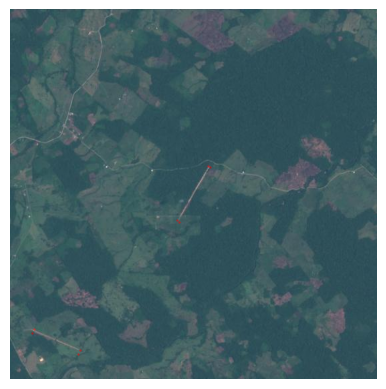

In [18]:
plt.imshow(image)

for i in range(len(keypoints)):
    plt.scatter([x[0] for x in keypoints[i]], [x[1] for x in keypoints[i]], c='r',s = 0.1)

plt.axis('off')
plt.show()

In [ ]:
plt.imshow(image)

rgba_mask = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_mask[segmentations[1] == 1] = [255, 0, 0, 40]

plt.imshow(rgba_mask)

In [ ]:
train_rotated = []
for i in range(len(train_image_and_paths)):
    image, lines, _, _ = train_image_and_paths[i]
    masks = []
    total_points = []
    for line in lines:
        points = get_keypoints_from_line(line, image.height, image.width)
        total_points.extend(points)
        masks.append(keypoints_to_seg(image, KeypointsOnImage(points, shape=image.size)))

    if len(masks) == 0:
        masksOnImage = None
    else:
        masksOnImage = SegmentationMapsOnImage(np.stack(masks, axis=-1), shape=image.size)

    image_aug, masks_aug = augment_image_and_seg_and_keypoints(image, masksOnImage, total_points, rotate)

    train_rotated.append((image_aug, masks_aug))

In [15]:
image, masks = train_rotated[0]
width, height = image.size
empty = False
relative_x = [keypoint.x for keypoint in keypoints.keypoints]
relative_y = [keypoint.y for keypoint in keypoints.keypoints]

x_min = min(relative_x)
x_max = max(relative_x)
y_min = min(relative_y)
y_max = max(relative_y)

x_min_valid = max(0, x_max - crop_size)
x_max_valid = min(width - crop_size, x_min)
y_min_valid = max(0, y_max - crop_size)
y_max_valid = min(height - crop_size, y_min)

if x_min_valid >= x_max_valid or y_min_valid >= y_max_valid or x_max_valid - x_min_valid < 0.5 or y_max_valid - y_min_valid < 0.5:
    print("Invalid crop for image " + image_path)

crop_x = random.randint(math.ceil(x_min_valid), math.floor(x_max_valid))
crop_y = random.randint(math.ceil(y_min_valid), math.floor(y_max_valid))

crop = image.crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size))

if not empty:
    relative_x = [(x - crop_x) for x in relative_x]
    relative_y = [(y - crop_y) for y in relative_y]
    
    string = '0 '
    for x, y in zip(relative_x, relative_y):
        string += str(x / crop_size) + ' ' + str(y / crop_size) + ' '
else:
    string = ''
# return (crop, string)

In [ ]:
train_cropped = []
for i, rotated in enumerate(train_rotated):
    for _ in range(10):
        image, keypoints = rotated
        cropped = crop(image, keypoints)
        if cropped is not None:
            
            train_cropped.append(cropped)

In [ ]:
test_cropped = []
for i, rotated in enumerate(test_image_and_paths):
    image, lines, _, _ = rotated
    points = []
    for line in lines:
        points += get_keypoints_from_line(line, image.height, image.width)
    cropped = crop(image, KeypointsOnImage(points, shape=image.size))
    if cropped is not None:
        test_cropped.append(cropped)

In [ ]:
val_cropped = []
for i, rotated in enumerate(val_image_and_paths):
    image, lines, _, _ = rotated
    points = []
    for line in lines:
        points += get_keypoints_from_line(line, image.height, image.width)
    cropped = crop(image, KeypointsOnImage(points, shape=image.size))
    if cropped is not None:
        val_cropped.append(cropped)

In [ ]:
for i in range(len(train_cropped)):
    for _ in range(2):
        image, line = train_cropped[i]
        try:
            image, keypoints = augment_image_and_keypoints(image, line, seq)
        except:
            continue
        line = ''
        if len(keypoints.keypoints) > 0:
            line = '0 '
        for keypoint in keypoints.keypoints:
            if keypoint.x < 0 or keypoint.y < 0 or keypoint.x > crop_size or keypoint.y > crop_size:
                print("Invalid keypoint: " + str(keypoint.x/crop_size) + " " + str(keypoint.y/crop_size))
            line += str(keypoint.x/crop_size) + ' ' + str(keypoint.y/crop_size) + ' '
        train_cropped[i] = (image, line)

In [ ]:
print("Train size: " + str(len(train_cropped)))
print("Val size: " + str(len(val_cropped)))
print("Test size: " + str(len(test_cropped)))

In [21]:
# from matplotlib import pyplot as plt
# for idx, (image, data) in enumerate(train_cropped):
#     # Convert PIL Image to NumPy array
#     img_array = np.array(image)
    
#     # Create a Matplotlib figure and axis
#     plt.figure(figsize=(8, 6))
#     plt.imshow(img_array)
#     plt.axis('off')  # Hide axis
    
#     # Parse the data string to extract coordinates
#     points = data.strip().split()
    
#     # Assuming the first element is a label, skip it
#     coords = points[1:]
    
#     # Ensure that there is an even number of coordinates
#     if len(coords) % 2 != 0:
#         raise ValueError(f"Odd number of coordinates in data: {data}")
    
#     # Extract x and y coordinates, scaling them by crop_size
#     x_coords = []
#     y_coords = []
#     for i in range(0, len(coords), 2):
#         x = float(coords[i]) * crop_size
#         y = float(coords[i+1]) * crop_size
#         x_coords.append(x)
#         y_coords.append(y)
    
#     # Plot the points on the image
#     plt.scatter(x_coords, y_coords, c="red", s=0.5, marker='o', edgecolors='white')
    
#     # Optionally, add titles or annotations
#     plt.title(f'Image {idx+1} with Points')
    
#     plt.show()

In [22]:
folder = "train"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in train_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [23]:
folder = "test"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in test_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [24]:
folder = "valid"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in val_cropped:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)